# Analyzing NYC High School Data

The goal of this project is to explore relationships between SAT scores and demographic factors of high schools in New York City. The SAT is a standardized test, that high school seniors take every year. It has three sections witch 800 maximum points each, which makes the combined maximal score 2,400. High average SAT scores are usually an indicator for a good school. 

I combined a number of data sets into a single pandas dataframe

### First Steps

In [1]:
import pandas as pd
import numpy
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]



### Plotting survey correlations

I want to explore possible correlations between survey data and SAT scores. I will use visualizations to make the information more comprehensible.

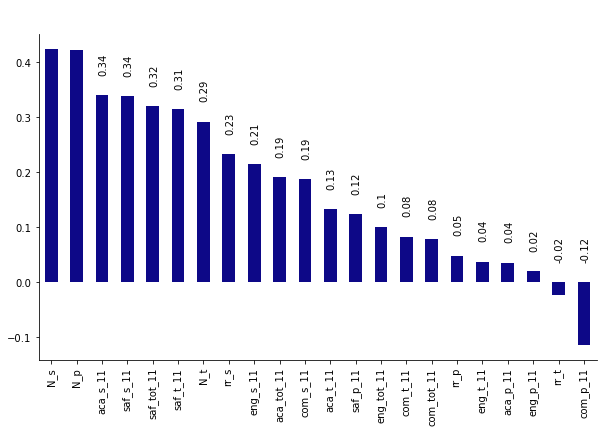

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Creating a bar plot
%matplotlib inline
ax = correlations[survey_fields].sort_values(ascending=False).plot(y="Correlation", kind="bar",figsize=(10, 6), colormap="plasma")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x()+0.1, max(p.get_height(), 0)+0.04),
                rotation=90
                )
plt.show();

The highest correlations are found between the SAT score and the number of student respondents aswell as the number of the parent respondents with 0.42. It seams, that large schools produce better SAT scores.

The group with the second highest correlation ranges from 0.29 to 0.34 and includes academic expectations of students, safety and respect and the number of teachers. The number of teachers also points towards larger schools having higher SAT scores on average. A connection between safety and respect and better performance is not surprising. A good learning environment will result in better performing students. The academic expectations of students score is also highly correlated, which makes sense, because students can evaluate their own performance usually rather accurately. 

The fields with no significant correlation are:  response rate of parents, engagement score based on teacher responses, academic expectations score based on parent responses, engagement score based on parent responses and teacher response rate. 
Some of those results are surprising, because we usually would assume a relationship between those factors and students performance. Three of those non-correlated factors being based on the parents could mean, that the influence of parents on their childrens school performance is rather small. This might be a phenomenon worthy of further investigation.

The only field with a negative correlation is communication score based on parent responses.

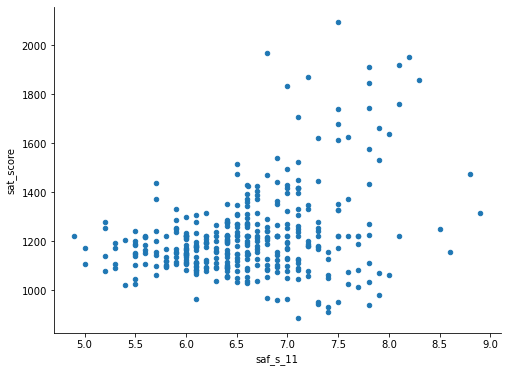

In [11]:
ax = combined.plot(x="saf_s_11", y="sat_score", kind="scatter",figsize=(8, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# Average safety scores

In [12]:
district_safety_avg = combined.groupby("school_dist").agg(numpy.mean)
print(district_safety_avg["saf_tot_11"].sort_values(ascending=False))

school_dist
22    7.850000
24    7.753846
04    7.714286
12    7.666667
06    7.660000
20    7.620000
30    7.577778
25    7.525000
02    7.520833
28    7.463636
14    7.435714
01    7.433333
07    7.392308
32    7.383333
09    7.365000
13    7.269231
10    7.268182
03    7.233333
08    7.218182
31    7.200000
26    7.140000
18    7.109091
21    7.090909
11    7.086667
05    7.085714
23    7.066667
27    7.010000
29    6.962500
17    6.935714
15    6.933333
19    6.758333
16    6.325000
Name: saf_tot_11, dtype: float64


In [13]:
from mpl_toolkits.basemap import Basemap

longitudes = district_safety_avg["lon"].tolist()
latitudes = district_safety_avg["lat"].tolist()

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=0.4)

m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=district_safety_avg["saf_tot_11"],cmap="Greens")
plt.title("District Safety Perception")
plt.colorbar()
plt.show()

OSError: Unable to open boundary dataset file. Only the 'crude' and  'low',
resolution datasets are installed by default.
If you are requesting an, 'intermediate', 'high' or 'full'
resolution dataset, you may need to download and install those
files separately with
`conda install -c conda-forge basemap-data-hires`.

There seems to be an area in the northern half of Brooklyn, where the perceived safety is generally lower than in the rest of the city. The southern part of Brooklyn has the safest district of the entire city, while the nothern part has the least safe. Brooklyn appers to be a borough of great contrasts.
Districts at the periphery of Queens are also less safe than districts closer to the center. The distribution in the Manhattan, Bronx and Staten Island is relatively even, with very safe districts and districts of average safety.

### Ethnic differences

In [ ]:
from scipy.stats.stats import pearsonr

e_fields = ["white_per", "asian_per", "black_per", "hispanic_per", "sat_score"]
e_corr = combined[e_fields].corr()
e_corr = e_corr["sat_score"]
e_corr = e_corr.drop(["sat_score"])



ax = e_corr.plot(kind="bar")

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x()+0.1, max(p.get_height(), 0)+0.12),
                rotation=90
                )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show();

In [ ]:
ax = combined.plot(x="hispanic_per", y="sat_score", kind="scatter",figsize=(8, 6))
plt.show()

There appears to be a negative correlation of -0.4 between the ratio of hispanic students and SAT scores. The best schools, which have a score of 1500 or better never have more than 25% hispanic students. On the other hand, some of the worst scoring schools have close to 100% hispanic students.
We have to be careful about the conclusions we draw from this information. Lets take a closer look at the schools, which have more than 95 % hispanic students aswell as the schools with less than 10% hispanic students and a SAT score over 1800.

In [ ]:
hispanic = combined[combined["hispanic_per"]>95]
print(hispanic)

In [ ]:
non_hispanic = combined[(combined["hispanic_per"]>10) & (combined["sat_score"]>1800)]
print(non_hispanic)


After researching the schools name, we can conclude that the schools with majority of hispanic students are mainly catering to hispanic immigrants, which would explain lower scores, since english is not their first language. Economic background can also be a factor that influences performance.

The schools with less than 10% hispanic students and very high SAT scores are all specialized high schools with additional funding and entrance exams.

In [ ]:
# Advanced Placement Test takers

In [ ]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
ax = combined.plot(x="ap_per", y="sat_score", kind="scatter",figsize=(8, 6))


It appears, that the schools with the highes SAT scores (1.900 and more) have a rate of AP test takers of 40 - 60%. The schools with higher rates of AP test takers (60% and more) all have lower SAT scores of 1.100 - 1.300. The doesn't seem to be a strong connection between high rates of AP test takers and the SAT score. 